In [34]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

## Boosting For Regression Trees

Here we implement the boosting algorithm 8.2 in ISLR, and test the effect of the learning rate on the test performance. We also compare the performance to the default sklearn implementations of Adaboost and Random Forest. First, we download the California Housing regression dataset, and perform a 80-20 train-test split:

In [6]:
X, y = fetch_california_housing(return_X_y=True)
X.shape, y.shape

((20640, 8), (20640,))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Boosting Tree Regressor Implementation

We use the same default estimator as the sklearn implementation, which uses `DecisionTreeRegressor` with `max_depth=3`.

In [28]:
class BoostingTreeRegressor:
    def __init__(self, M=100, l=0.01, depth=3) -> None:
        self.M = M
        self.l = l
        self.depth = depth
        self.trees = []

    def fit(self, X: np.array, y: np.array):
        for _ in range(self.M):
            clf = DecisionTreeRegressor(max_depth=self.depth)
            clf.fit(X, y)
            pred = clf.predict(X)
            y = y - pred * self.l
            self.trees.append(clf)

    def predict(self, X: np.array):
        y_pred = np.zeros(X.shape[0])
        for tree in self.trees:
            y_pred += self.l * tree.predict(X)

        return y_pred
    

clf = BoostingTreeRegressor()
clf.fit(X_train, y_train)
mean_absolute_error(y_test, clf.predict(X_test))

0.8189156151578068

## Grid Search over Learning Rate

Now we investigate the effect of learning rate for the following grid of learning rates. Note that technically, learning rate can go to $+ \infty$, but I noticed that using a learning rate greater than 1 resulted in horrible prediction accuracy. We are using MAE as our metric for comparing the different classifiers.

In [51]:
learning_rate_grid = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
mae = []
adaboost_mae = []

for lr in learning_rate_grid:
    clf = BoostingTreeRegressor(l=lr, M=50)
    clf.fit(X_train, y_train)
    mae.append(mean_absolute_error(y_test, clf.predict(X_test)))


    clf = AdaBoostRegressor(learning_rate=lr)
    clf.fit(X_train, y_train)
    adaboost_mae.append(mean_absolute_error(y_test, clf.predict(X_test)))

In [52]:
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
rf_mae = mean_absolute_error(y_test, clf.predict(X_test))

The following graph plots the test MAE of our boosting algorithm, Adaboost, and Random Forest as a function of learning rate. Note that Random Forest does not use a learning rate, so we set its performance as a constant value. Also, we matched the default parameters of Adaboost, which uses 50 iterations.

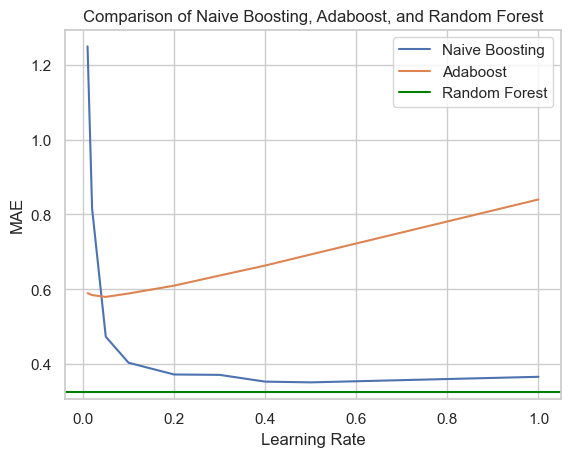

In [54]:
sns.set(style="whitegrid")
sns.lineplot(x=learning_rate_grid, y=mae, label='Naive Boosting')
sns.lineplot(x=learning_rate_grid, y=adaboost_mae, label='Adaboost')

# Add the legend
plt.axhline(rf_mae, color='green', label = 'Random Forest')
plt.legend(loc='upper right')

# Set the x and y axis labels
plt.xlabel('Learning Rate')
plt.ylabel('MAE')

# Set the title of the plot
plt.title('Comparison of Naive Boosting, Adaboost, and Random Forest');

Several interesting things happened here. First, the Random Forest performed better than both AdaBoost and our implementation of boosting. It's also interesting that the naive boosting performed better than AdaBoost, even though the latter is a more involved algorithm. In general, a lower learning rate seems to be better for performance. Especially for AdaBoost it seems that the learning rate needs to be tuned, because the default is 1, which performs badly.

Let's see if anything changes if we increase the number of boosting iterations from 50 to 500.

In [55]:
learning_rate_grid = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
mae = []
adaboost_mae = []

for lr in learning_rate_grid:
    clf = BoostingTreeRegressor(l=lr, M=500)
    clf.fit(X_train, y_train)
    mae.append(mean_absolute_error(y_test, clf.predict(X_test)))


    clf = AdaBoostRegressor(learning_rate=lr, n_estimators=500)
    clf.fit(X_train, y_train)
    adaboost_mae.append(mean_absolute_error(y_test, clf.predict(X_test)))

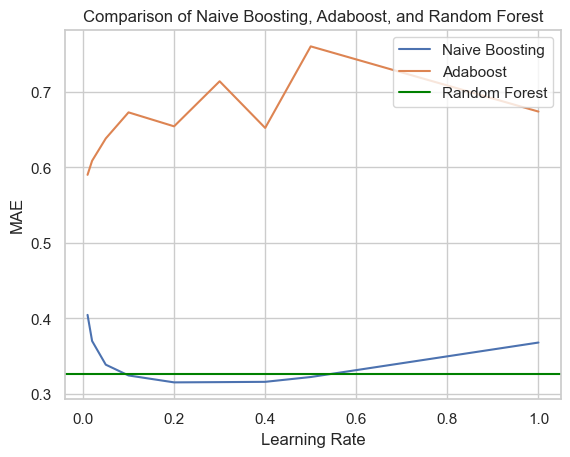

In [56]:
sns.set(style="whitegrid")
sns.lineplot(x=learning_rate_grid, y=mae, label='Naive Boosting')
sns.lineplot(x=learning_rate_grid, y=adaboost_mae, label='Adaboost')

# Add the legend
plt.axhline(rf_mae, color='green', label = 'Random Forest')
plt.legend(loc='upper right')

# Set the x and y axis labels
plt.xlabel('Learning Rate')
plt.ylabel('MAE')

# Set the title of the plot
plt.title('Comparison of Naive Boosting, Adaboost, and Random Forest');

Naive boosting slightly outperforms the random forest when the learning rate is between 0.2 and 0.4. Perhaps for AdaBoost we must set the learning rate even smaller, to maybe 0.001.